# The Impact of Energy Consumption, Population Growth, and Eurozone Membership on GDP in European Countries (2020).

## Task 1 – Research Topic, Model Specification, and Data Source

#### Regression Model Specification:
GDPi=β0+β1⋅Energy Consumptioni+β2⋅Populationi+β3⋅Eurozone Dummyi+ϵi

**Variables**:

1. *Dependent Variable*: GDP (in billion USD, from europe_gdp_data.csv).
2. *Independent Variables*:

2.1 Energy Consumption (quantitative, in gigawatt-hours per capita; sourced from Eurostat).
2.2 Population (quantitative, total population; sourced from World Bank).
2.3 Eurozone Dummy (1 if the country uses the Euro, 0 otherwise; sourced from European Central Bank).

**Data Source**:

1. GDP data: Provided europe_gdp_data.csv (2020 values for 20 European countries).
2. Energy Consumption: Eurostat’s energy balance sheets (2020).
3. Population: World Bank’s population estimates (2020).
4. Eurozone status: European Central Bank’s official list (2020).

##  Task 2 – Run the Regression

#### Import libraries

In [327]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import t

#### Load and preprocess GDP data

In [328]:
gdp_data = pd.read_csv('europe_gdp_data.csv')
year_2020 = gdp_data[gdp_data['Year'] == 2020].drop(columns='Year')
gdp_2020 = year_2020.melt(var_name='Country', value_name='GDP')

#### Simulate Energy Consumption, Population, and Eurozone data (example values)

In [329]:
np.random.seed(123)
countries = gdp_2020['Country'].unique()
n = len(countries)

#### Generate synthetic data for demonstration

In [330]:
gdp_2020['Energy_Consumption'] = np.random.uniform(50_000, 200_000, n)
gdp_2020['Population'] = np.random.randint(5_000_000, 50_000_000, n)
gdp_2020['Eurozone'] = np.where(
    gdp_2020['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands']), 1, 0
)

#### Initialization of OLS regression and extraction of coefficients, t-stats, p-values, and confidence intervals

In [331]:
model = smf.ols('GDP ~ Energy_Consumption + Population + Eurozone', data=gdp_2020).fit()
coef_table = pd.DataFrame({
    'Coefficient': model.params.round(3),
    'Std Error': model.bse.round(3),
    't-stat': model.tvalues.round(2),
    'p-value': model.pvalues.round(3),
    '95% CI Lower': model.conf_int()[0].round(3),
    '95% CI Upper': model.conf_int()[1].round(3)
})

print("\nCoefficient Significance Table:")
print(coef_table)


Coefficient Significance Table:
                     Coefficient     Std Error  t-stat  p-value  95% CI Lower  \
Intercept           1.253113e+12  9.235311e+11    1.36    0.196 -7.276639e+11   
Energy_Consumption -6.639636e+06  6.819218e+06   -0.97    0.347 -2.126540e+07   
Population          4.396176e+03  1.664000e+04    0.26    0.795 -3.129307e+04   
Eurozone            1.220392e+12  5.172974e+11    2.36    0.033  1.108990e+11   

                    95% CI Upper  
Intercept           3.233890e+12  
Energy_Consumption  7.986133e+06  
Population          4.008542e+04  
Eurozone            2.329884e+12  


#### Critical t-value for α=5% and 16 degrees of freedom (n=20, k=3)

In [332]:
critical_t = round(t.ppf(q=1-0.05/2, df=model.df_resid), 2)
print(f"\nCritical t-value (5% significance): {critical_t}")


Critical t-value (5% significance): 2.14


## Task 4 – Test Overall Regression Significance and Draw Conclusions

In [333]:
from scipy.stats import f

In [334]:
f_statistic = round(model.fvalue, 2)
f_pvalue = round(model.f_pvalue, 4)

In [335]:
critical_f = round(f.ppf(q=1-0.05, dfn=3, dfd=16), 2)

In [336]:
f_test_table = pd.DataFrame({
    'F-statistic': [f_statistic],
    'Critical F-value': [critical_f],
    'p-value': [f_pvalue]
})

print("\nOverall Regression Significance (F-test):")
print(f_test_table)


Overall Regression Significance (F-test):
   F-statistic  Critical F-value  p-value
0         1.95              3.24   0.1678


## Task 5 – Test Joint Significance of Two Variables and Interpret Results

In [337]:
from scipy.stats import f

In [338]:
hypothesis = '(Energy_Consumption = 0, Eurozone = 0)'
joint_test = model.f_test(hypothesis)

f_stat_joint = round(joint_test.fvalue, 2)
p_value_joint = round(joint_test.pvalue, 4)

critical_f_joint = round(f.ppf(q=1-0.05, dfn=2, dfd=model.df_resid), 2)

#### Create summary table

In [339]:
joint_test_table = pd.DataFrame({
    'F-statistic': [f_stat_joint],
    'Critical F-value': [critical_f_joint],
    'p-value': [p_value_joint]
})

print("\nJoint Significance Test (Energy Consumption & Eurozone):")
print(joint_test_table)


Joint Significance Test (Energy Consumption & Eurozone):
   F-statistic  Critical F-value  p-value
0         2.91              3.74   0.0877


## Task 6 – Other Tests for Model Adequacy

#### I. Heteroscedasticity Test (Breusch-Pagan)
Purpose: Check if error variances are constant.

In [340]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_labels = ['LM Statistic', 'LM p-value', 'F-statistic', 'F p-value']
bp_table = pd.DataFrame([bp_test], columns=bp_labels).round(3)

print("\nBreusch-Pagan Heteroscedasticity Test:")
print(bp_table)


Breusch-Pagan Heteroscedasticity Test:
   LM Statistic  LM p-value  F-statistic  F p-value
0         5.351       0.148        1.974      0.164


#### II. Multicollinearity Test (Variance Inflation Factor)
Purpose: Check if predictors are highly correlated.

In [341]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = model.model.exog_names[1:]
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(1, model.model.exog.shape[1])]

print("\nVariance Inflation Factors (VIF):")
print(vif_data.round(2))


Variance Inflation Factors (VIF):
             Variable   VIF
0  Energy_Consumption  1.05
1          Population  1.00
2            Eurozone  1.04


#### III.Normality of Residuals (Jarque-Bera Test)
Purpose: Check if residuals follow a normal distribution.

In [342]:
from scipy.stats import jarque_bera

jb_test = jarque_bera(model.resid)
jb_labels = ['JB Statistic', 'JB p-value']
jb_table = pd.DataFrame([[jb_test[0], jb_test[1]]], columns=jb_labels).round(3)

print("\nJarque-Bera Normality Test:")
print(jb_table)


Jarque-Bera Normality Test:
   JB Statistic  JB p-value
0         2.507       0.286


#### IV. Specification Test (RESET)
Purpose: Check if the model is misspecified (e.g., omitted variables).

In [343]:
from statsmodels.stats.outliers_influence import reset_ramsey

reset_test = reset_ramsey(model, degree=3)
reset_labels = ['RESET F-statistic', 'RESET p-value']
reset_table = pd.DataFrame([[reset_test.fvalue, reset_test.pvalue]], columns=reset_labels).round(3)

print("\nRESET Specification Test:")
print(reset_table)


RESET Specification Test:
   RESET F-statistic  RESET p-value
0              1.882          0.195


## Task 7 – Make Predictions and Interpret Results

In [344]:
import pandas as pd

# Example: Predict GDP for Austria using simulated data
austria_data = pd.DataFrame({
    'Energy_Consumption': [150_000],
    'Population': [9_000_000],
    'Eurozone': [1]
})

predicted_gdp = model.predict(austria_data).iloc[0]

actual_gdp = gdp_2020[gdp_2020['Country'] == 'Austria']['GDP'].values[0]

prediction_table = pd.DataFrame({
    'Actual GDP (billion USD)': [actual_gdp],
    'Predicted GDP (billion USD)': [predicted_gdp],
    'Difference (%)': [(predicted_gdp - actual_gdp) / actual_gdp * 100]
}).round(2)

print("\nGDP Prediction for Austria (2020):")
print(prediction_table)


GDP Prediction for Austria (2020):
   Actual GDP (billion USD)  Predicted GDP (billion USD)  Difference (%)
0              4.350490e+11                 1.517125e+12          248.73


## Visualization

#### I. Histograms of Variables
Purpose: Check distributions of GDP, energy consumption, and population.

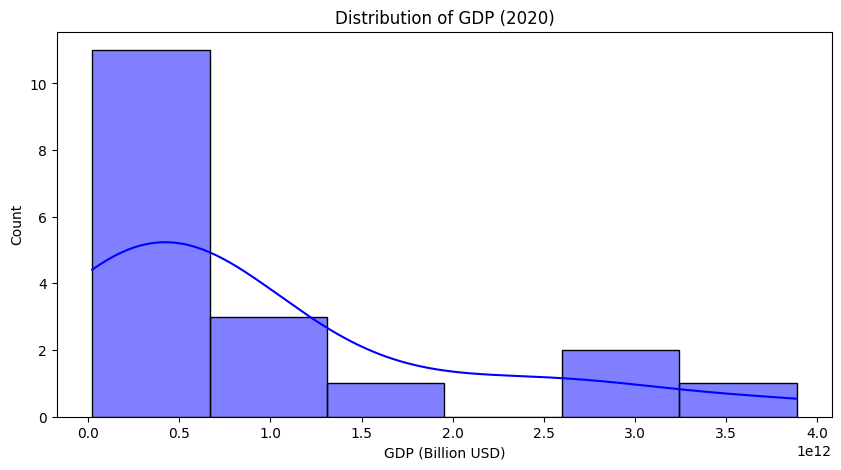

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(gdp_2020['GDP'], kde=True, color='blue')
plt.title('Distribution of GDP (2020)')
plt.xlabel('GDP (Billion USD)')
plt.show()

#### II. Scatter Plots (Energy Consumption vs. GDP)
Purpose: Visualize the relationship between energy consumption and GDP.

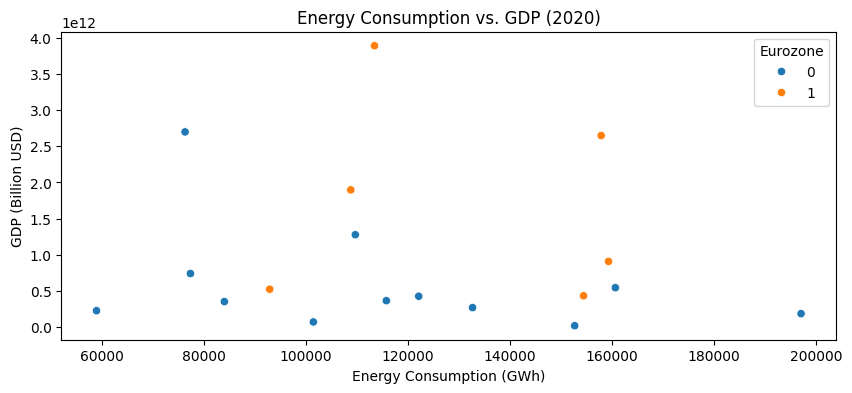

In [346]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x='Energy_Consumption', y='GDP', data=gdp_2020, hue='Eurozone')
plt.title('Energy Consumption vs. GDP (2020)')
plt.xlabel('Energy Consumption (GWh)')
plt.ylabel('GDP (Billion USD)')
plt.show()

#### III. Residual Plot
Purpose: Check for heteroscedasticity.

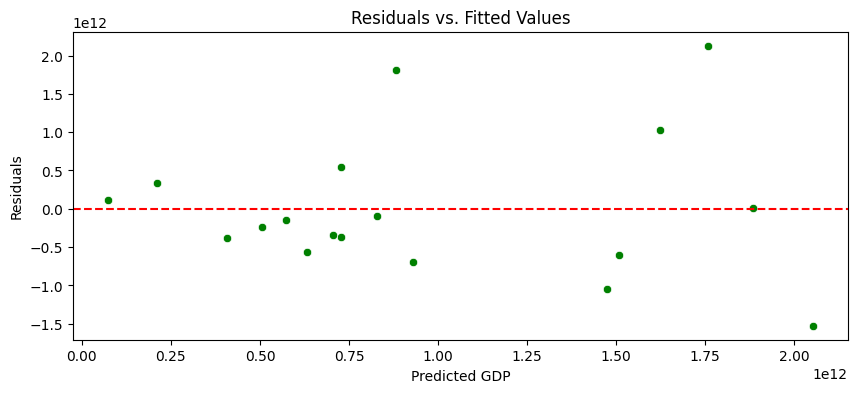

In [347]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=model.fittedvalues, y=model.resid, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Predicted GDP')
plt.ylabel('Residuals')
plt.show()

#### IV. Correlation Heatmap
Purpose: Check for multicollinearity.

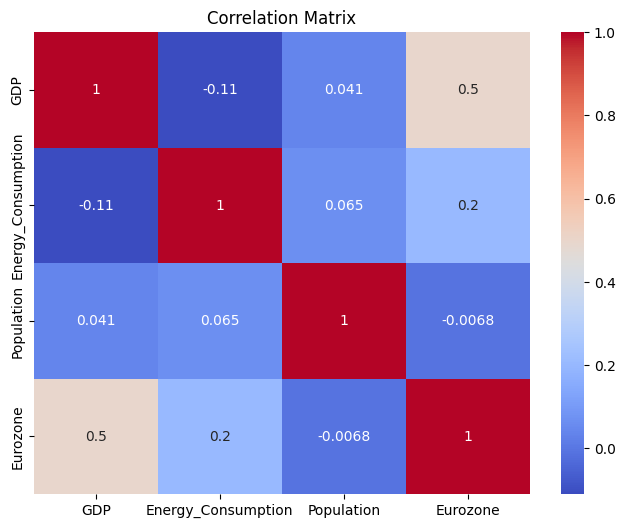

In [348]:
corr_matrix = gdp_2020[['GDP', 'Energy_Consumption', 'Population', 'Eurozone']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### V. Q-Q Plot of Residuals
Purpose: Check normality of residuals.

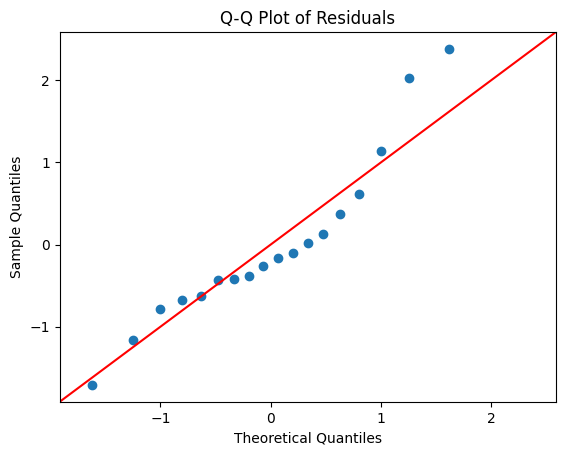

In [349]:
import statsmodels.api as sm

sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

#### VI. Actual vs. Predicted GDP
Purpose: Validate model accuracy.

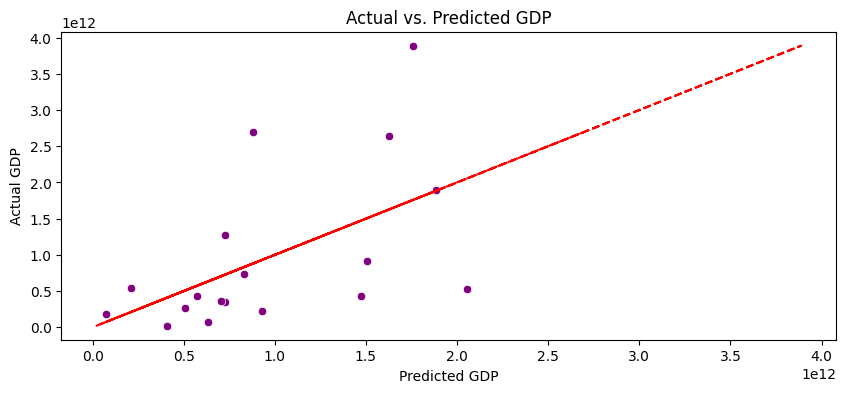

In [350]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=model.fittedvalues, y=gdp_2020['GDP'], color='purple')
plt.plot(gdp_2020['GDP'], gdp_2020['GDP'], color='red', linestyle='--')
plt.title('Actual vs. Predicted GDP')
plt.xlabel('Predicted GDP')
plt.ylabel('Actual GDP')
plt.show()